In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as m
import os
import tensorflow as tf
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Multiply, Permute, Activation, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Reshape, Multiply
from keras.regularizers import l2

from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

from collections import Counter

In [3]:
loc = '/content/gdrive/My Drive/Colab Notebooks/Kelas Basic/input/Malocclusion2'
loc1 = '/content/gdrive/My Drive/Colab Notebooks/Kelas Basic/input/Malocclusion'
model_loc = '/content/gdrive/My Drive/Colab Notebooks/Kelas Basic/'

dataset1 = pd.read_excel(loc+'/Label_SI.xlsx')
dataset2 = pd.read_excel(loc1+'/Label_SI.xlsx')
dataset1.head() # display first 5 row data

,NAMA,RN,GENDER,NO XRAY,AGE,SK,INCISOR,CANINE,MOLAR,RACE
0,ALIAH ABDUL AZIZ,266,F,2,20,1.0,2 DIV1,NaN,R1 L1,M
1,AAISYAH NAADHIRAH BINTI MOHD ZAID,1544,F,5,19,1.0,1,R3 L2,R2 L1,M
2,ABDUL MUIZ BIN LOKMAN,6107,F,6,19,1.0,1,R3 L2,R2 L1,M
3,ADAWIYA ISMAIL,5488,F,7,23,3.0,3,R2 L3,R- L3,M
4,ADIBAH HAWAYA BINTI AL KHIRUL NIZAM,1088,F,8,13,1.0,1,NaN,NaN,M


In [4]:
def handle_labels(dataset1,dataset2):
  dataset1['SK'].replace('', np.nan, inplace=True)
  dataset1.dropna(subset=['SK'], inplace=True)

  file_name_dataset1 = dataset1['NO XRAY'].astype('string')
  file_name_dataset2 = dataset2['Code_no'].astype('string')
  label1 = dataset1['SK'].astype('int').astype('string')
  label2 = dataset2['maloc'].astype('int').astype('string')

  labels = np.concatenate([label1, label2])
  print('Total image=',file_name_dataset1.size+file_name_dataset2.size,'Total label=',labels.size)

  return labels, file_name_dataset1, file_name_dataset2

In [5]:
labels, file_name_dataset1, file_name_dataset2 = handle_labels(dataset1,dataset2)
Counter(labels)

Total image= 858 Total label= 858


<ipython-input-4-b183afcf4156>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset1['SK'].replace('', np.nan, inplace=True)


Counter({'1': 414, '3': 137, '2': 307})

In [6]:
def remove_image_info(image,img_size):
    h, w = image.shape
    y1 = 0
    y2 = int(0.90*h)
    x1 = 0
    x2 = w
    return cv2.resize(image[y1:y2,x1:x2],img_size)

In [7]:
def img_pre_process_pipeline(file_name_dataset1, file_name_dataset2,img_size):
  X_data =[]
  for file in file_name_dataset1:
      img = cv2.resize(cv2.imread(loc+'/'+file+'.jpg',0),img_size)
      X_data.append(remove_image_info(img,img_size))

  for file in file_name_dataset2:
      img = cv2.resize(cv2.imread(loc1+'/'+file+'.jpg',0),img_size)
      X_data.append(img)

  X = np.array(X_data)
  X = np.squeeze(X) #remove single-dimensional entries from the shape of an array
  X = np.array(X)
  X = X.astype('float32')
  X /= 255
  X = X.reshape(-1,img_size[0],img_size[0],1)

  return X

In [8]:
def label_pipeline(label,num_class):
  label_encoder = preprocessing.LabelEncoder()
  Y = label_encoder.fit_transform(label)
  Y = to_categorical(Y, num_classes = num_class)
  return Y

In [9]:
img_size = 64
X = img_pre_process_pipeline(file_name_dataset1, file_name_dataset2,(img_size,img_size))
Y = label_pipeline(labels,3)

In [10]:
# Split the data into training (70%) and the rest (30%)
X_train, X_temp, Y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Split the remaining data into validation (20%) and testing (10%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [11]:
print(len(X_train),len(X_val),len(X_test))
print(len(Y_train),len(Y_val),len(Y_test))
Counter(np.argmax(Y_test, axis=1))

600 172 86
600 172 86


Counter({2: 19, 0: 36, 1: 31})

In [12]:
train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

train_generator.fit(X_train,augment=True)
val_generator.fit(X_val,augment=True)

train = train_generator.flow(X_train, Y_train, batch_size=16)
val = val_generator.flow(X_val, Y_val, batch_size=16)

In [43]:
def attention_shape_cnn():
  model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(shape=(img_size, img_size, 1)),  # 👈 Ensure explicit input shape
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(3, activation='softmax',kernel_regularizer=l2(0.01))])

  model.summary()
  return model

model = attention_shape_cnn()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,843 (9.44 MB)

 Trainable params: 2,474,307 (9.44 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [44]:
# Define optimizer with a fixed learning rate
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])  # Changed 'acc' to 'accuracy' (more explicit)

In [45]:
# Define callbacks

# Define the ReduceLROnPlateau callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation loss
    factor=0.05,          # Reduce learning rate by multiplying with this factor
    patience=40,          # Wait for 5 epochs before reducing LR
    min_lr=1e-6,         # Minimum learning rate to avoid going too low
    verbose=1            # Print updates when LR is reduced
)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=70,  # Stop training if no improvement for 20 epochs
                              #  restore_best_weights=True,  # Restore best model
                               verbose=1,
                               mode = 'auto')

# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.5,  # Reduce LR by 50% on plateau
#                               patience=10,  # Reduce LR if no improvement for 10 epochs
#                               verbose=1,
#                               min_delta=0.01,  # Small improvement threshold
#                               min_lr=1e-6)  # Ensures LR doesn't go too low

callbacks_list = [early_stopping, lr_callback]

In [46]:
history = model.fit(train,  # Assuming 'train' is your training dataset
                    epochs=350,  # Train for 100 epochs
                    validation_data=val,  # Assuming 'val' is your validation dataset
                    callbacks=callbacks_list,
                    steps_per_epoch=len(X_train) // 16,  # Adjust batch size accordingly
                    verbose=1)

Epoch 1/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.3914 - loss: 1.3631 - val_accuracy: 0.4244 - val_loss: 1.1210 - learning_rate: 0.0050
Epoch 2/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.1094 - val_accuracy: 0.4535 - val_loss: 1.1071 - learning_rate: 0.0050
Epoch 3/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4158 - loss: 1.2149 - val_accuracy: 0.3488 - val_loss: 1.3435 - learning_rate: 0.0050
Epoch 4/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.0103 - val_accuracy: 0.3779 - val_loss: 1.4585 - learning_rate: 0.0050
Epoch 5/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4581 - loss: 1.0806 - val_accuracy: 0.1395 - val_loss: 1.5811 - learning_rate: 0.0050
Epoch 6/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.8591 - val_accuracy: 0.1395 - val_loss: 1.7294 - learning_rate: 0.0050
Epoch 7/350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4686 - loss: 1.0744 - val

In [48]:
# model.compile(loss='categorical_crossentropy',
#               metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

score = model.evaluate(X_test, Y_test, verbose=1)
print('\n', 'Normal Test accuracy:', score[1])

# # Print test accuracy
# print('\n', 'Best weight Test accuracy:', score[1])

model.save_weights(model_loc+"trained_model.weights.h5")

# model.load_weights(model_loc+"best_model.hdf5")
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('\n', 'Normal Test accuracy:', score[1])

# # # Print test accuracy
# print('\n', 'Best Model Test accuracy:', score[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5467 - loss: 1.3972

 Normal Test accuracy: 0.5465116500854492


In [28]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [29]:
import tensorflowjs as tfjs
import tensorflow as tf

In [49]:

# First, recreate the model with the same architecture
model = attention_shape_cnn()  # Assuming attention_shape_cnn is your model definition function

# Then, load the weights into the recreated model
model.load_weights(model_loc+'trained_model.weights.h5')

# Now you can proceed with converting the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, model_loc+'model_tfjs')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,843 (9.44 MB)

 Trainable params: 2,474,307 (9.44 MB)

 Non-trainable params: 1,536 (6.00 KB)

failed to lookup keras version from the file,
    this is likely a weight only file


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step


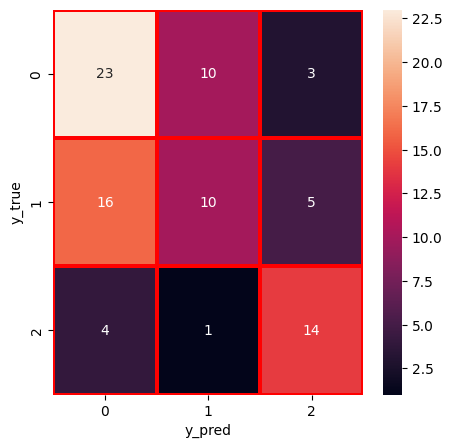

              precision    recall  f1-score   support

     class 1       0.53      0.64      0.58        36
     class 2       0.48      0.32      0.38        31
     class 3       0.64      0.74      0.68        19

    accuracy                           0.55        86
   macro avg       0.55      0.57      0.55        86
weighted avg       0.54      0.55      0.53        86



In [31]:
#labels = label.unique()
y_hat = model.predict(X_test)
y = np.round(y_hat)

y_pred = np.argmax(y_hat, axis=1)
y_pred = y_pred+1
y_true = np.argmax(Y_test, axis=1)
y_true = y_true+1

cm = confusion_matrix(y_true, y_pred, labels=[1,2,3])
#cm = confusion_matrix(y_true, y_pred, labels=labels.astype('int'))
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=1.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

target_names = ['class 1', 'class 2', 'class 3']

print(classification_report(y_true, y_pred, target_names=target_names))

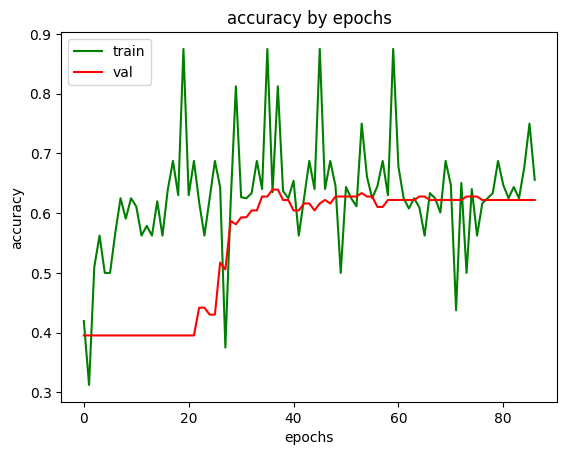

In [52]:
#from google.colab import files
fig = plt.plot(history.history["accuracy"],label = "train", color='green')
plt.plot(history.history["val_accuracy"],label = "val", color='red')
plt.legend(loc='upper left')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy by epochs")
#plt.savefig('acc.png')
#files.download('acc.png')
plt.show()

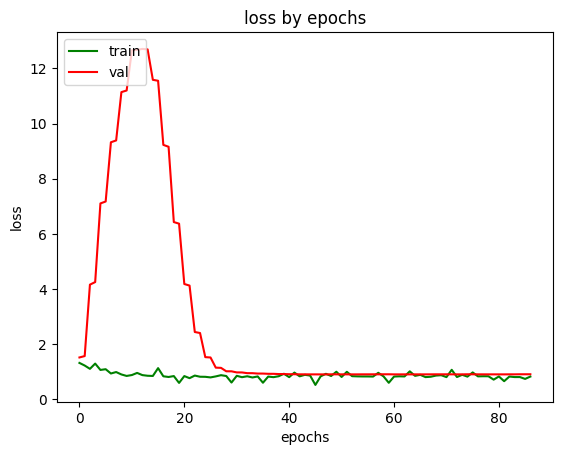

In [53]:
fig = plt.plot(history.history["loss"],label = "train", color='green')
plt.plot(history.history["val_loss"],label = "val", color='red')
plt.legend(loc='upper left')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss by epochs")
#plt.savefig('loss.png')
#files.download('loss.png')
plt.show()